In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import islice
import sys
print(sys.version)
print(spark.version)

3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:10) 
[GCC 10.3.0]
3.1.3


In [2]:
from google.cloud import storage

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
# from pyspark.sql import functions as F
from pyspark.sql.types import *

# Create spark_session
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [4]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [5]:
# pip install nltk -U

In [6]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
bucket_write = 'msca-bdp-students-bucket/shared_data_shuklakm'

gs_read_twitter_filt_path = 'gs://' + bucket_write + '/twitter_data/part-*.parquet'

gs_read_user_selected_data_filt_path = 'gs://' + bucket_write + '/user_selected_data_filt/part-*.parquet'
gs_read_retweeted_status_text_filt_path = 'gs://' + bucket_write + '/retweeted_status_text_filt/part-*.parquet'
gs_read_quoted_status_text_path = 'gs://' + bucket_write + '/quoted_status_text/part-*.parquet'


# original tweets


In [8]:
original_tweets = spark.read.parquet(gs_read_twitter_filt_path, header='true', inferSchema='true')

In [9]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [10]:
original_tweets.printSchema()

root
 |-- created_at: string (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp_ms: string (nullable = true)
 |-- description: string (nullable = true)
 |-- screen_name: string (nullable = true)
 |-- statuses_count: long (nullable = true)
 |-- retweeted_from: string (nullable = true)
 |-- reply_count: long (nullable = true)
 |-- retweet_count: long (nullable = true)
 |-- retweeted: boolean (nullable = true)



In [11]:
original_tweets.limit(5)

created_at,text,timestamp_ms,description,screen_name,statuses_count,retweeted_from,reply_count,retweet_count,retweeted
Thu Sep 15 01:03:...,RT @ARC_Storytell...,1663203818068,Widower. one awes...,gary101stones,320,ARC_Storyteller,2821,118,false
Thu Sep 15 01:03:...,RT @donnaking355:...,1663203818343,Maga-Patriot . ...,donnaking355,36817,donnaking355,1,1,false
Thu Sep 15 01:03:...,RT @kloogans: goi...,1663203818378,22. edgy but in a...,indeliblyicarus,29135,kloogans,3,115,false
Thu Sep 15 01:03:...,RT @yaetriplex: A...,1663203818695,link of all my ne...,Fraanookk,81510,yaetriplex,14,606,false
Thu Sep 15 01:03:...,RT @nathan_leitao...,1663203818705,eu fui a tua vida...,littlegoldxn,15807,nathan_leitao,43,198,false


In [73]:
original_tweets.groupby('text', 'reply_count').agg(count('retweet_count')).orderBy('count(retweet_count)', ascending=False).limit(5)

text,reply_count,count(retweet_count)
RT @thenyjew: for...,2,24694
RT @but_im_kim_tr...,30,5715
RT @thenyjew: for...,4,4835
RT @ifyouseekkae:...,2,4624
RT @burner4noah: ...,1,4575


In [12]:
original_tweets = original_tweets.withColumn('datetime', from_unixtime((original_tweets.timestamp_ms.cast('bigint')/1000)).cast('timestamp'))
original_tweets.limit(5)

created_at,text,timestamp_ms,description,screen_name,statuses_count,retweeted_from,reply_count,retweet_count,retweeted,datetime
Thu Sep 15 01:03:...,RT @ARC_Storytell...,1663203818068,Widower. one awes...,gary101stones,320,ARC_Storyteller,2821,118,false,2022-09-15 01:03:38
Thu Sep 15 01:03:...,RT @donnaking355:...,1663203818343,Maga-Patriot . ...,donnaking355,36817,donnaking355,1,1,false,2022-09-15 01:03:38
Thu Sep 15 01:03:...,RT @kloogans: goi...,1663203818378,22. edgy but in a...,indeliblyicarus,29135,kloogans,3,115,false,2022-09-15 01:03:38
Thu Sep 15 01:03:...,RT @yaetriplex: A...,1663203818695,link of all my ne...,Fraanookk,81510,yaetriplex,14,606,false,2022-09-15 01:03:38
Thu Sep 15 01:03:...,RT @nathan_leitao...,1663203818705,eu fui a tua vida...,littlegoldxn,15807,nathan_leitao,43,198,false,2022-09-15 01:03:38


In [13]:
original_tweets.describe()

KeyboardInterrupt: 

In [13]:
original_tweets = original_tweets.withColumn('created_month',month(original_tweets.datetime))
original_tweets.limit(4)

created_at,text,timestamp_ms,description,screen_name,statuses_count,retweeted_from,reply_count,retweet_count,retweeted,datetime,created_month
Thu Sep 15 01:03:...,RT @ARC_Storytell...,1663203818068,Widower. one awes...,gary101stones,320,ARC_Storyteller,2821,118,false,2022-09-15 01:03:38,9
Thu Sep 15 01:03:...,RT @donnaking355:...,1663203818343,Maga-Patriot . ...,donnaking355,36817,donnaking355,1,1,false,2022-09-15 01:03:38,9
Thu Sep 15 01:03:...,RT @kloogans: goi...,1663203818378,22. edgy but in a...,indeliblyicarus,29135,kloogans,3,115,false,2022-09-15 01:03:38,9
Thu Sep 15 01:03:...,RT @yaetriplex: A...,1663203818695,link of all my ne...,Fraanookk,81510,yaetriplex,14,606,false,2022-09-15 01:03:38,9


In [14]:
tweets_activity1 = original_tweets.groupby('created_month').agg(count('text')).orderBy('count(text)', ascending=False).limit(20).toPandas()
tweets_activity1.head(5)

,created_month,count(text)
0,5,9141143
1,9,7577870
2,6,7489820
3,10,7455888
4,8,7444747


Text(0, 0.5, 'Number of texts tweeted')

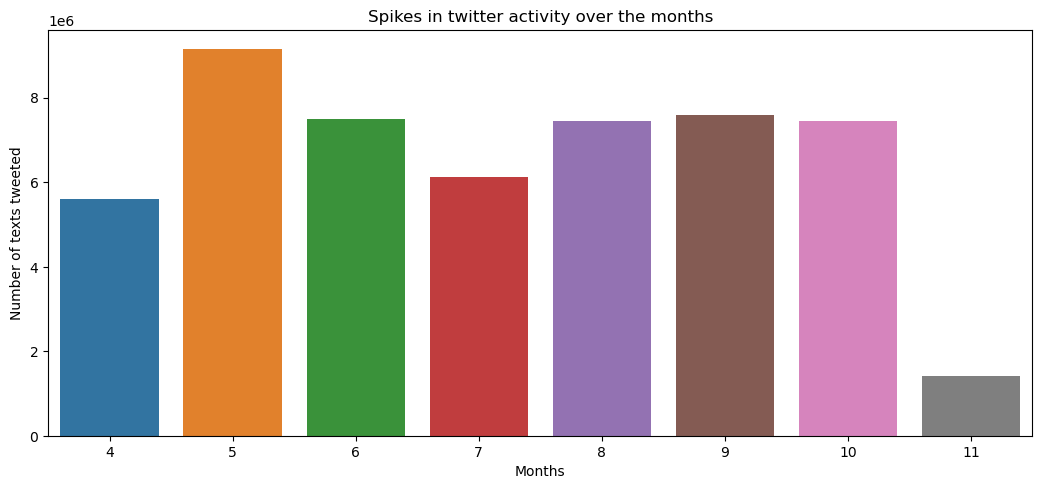

In [69]:
a4_dims = (12.7, 5.27)

fig, ax = plt.subplots(figsize=a4_dims)

# sns.scatterplot(data = b, x = "title" , y = "count(retweeted_text)", hue="title", ax=ax)
sns.barplot(data = tweets_activity1, x = "created_month" , y = "count(text)", ax=ax)

plt.title('Spikes in twitter activity over the months')
# Set x-axis label
plt.xlabel('Months')
# Set y-axis label
plt.ylabel('Number of texts tweeted')

In [18]:
tweets_activity2 = original_tweets.groupby('text', 'description').agg(avg('retweet_count')).orderBy('avg(retweet_count)', ascending=False)




In [19]:
tweets_activity_pandas = tweets_activity2.limit(5).toPandas()
tweets_activity_pandas.head(5)

,text,description,avg(retweet_count)
0,RT @nickjr: So about that time Steve went off to college… #BluesClues25 https://t.co/O8NOM2eRjy,"I'm just a regular Philadelphia Mf, Tryna make it 💯",516928.0
1,RT @nickjr: So about that time Steve went off to college… #BluesClues25 https://t.co/O8NOM2eRjy,GHS,516795.0
2,RT @nickjr: So about that time Steve went off to college… #BluesClues25 https://t.co/O8NOM2eRjy,Nft artist,516772.0
3,RT @nickjr: So about that time Steve went off to college… #BluesClues25 https://t.co/O8NOM2eRjy,just a boi,516711.0
4,RT @nickjr: So about that time Steve went off to college… #BluesClues25 https://t.co/O8NOM2eRjy,bts ot7! BLM | 20 | gal with big dreams | plant-based | human 🌱♓️🎵🌙✊🏽,516614.0


In [24]:
# tweets_activity2.\
# withColumn("Smoker_Binary",when(col("text") != 'yes', 1).otherwise(0))
# lung_df_cond.show(5)


# tweets_activity2.where(~F.col('text').contains('RT')).limit(5)
tweets_activity2.filter(~col("text").contains("RT"))


text,description,avg(retweet_count)


In [38]:
# tweet_df_cond = tweets_activity2.\
# withColumn("Topics",\
#            when(col("text").contains("school"), "School").\
#            when(col("text").contains("education"), "Education").\
#            otherwise("College")).limit(10).toPandas()

# tweet_df_cond.head(5)


tweet_df_cond = tweets_activity2.filter((col("text").contains("school")) | 
                                        (col("text").contains("education")) |
                                        (col("text").contains("knowledge")) 
                                       )

tweet_df_cond.limit(9)

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34899)
Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 977, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1115, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:34899)

<AxesSubplot:xlabel='Topics', ylabel='avg(retweet_count)'>

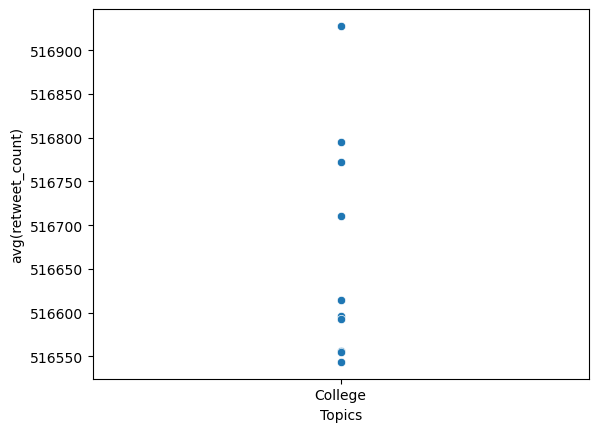

In [37]:
# sns.barplot(data = tweet_df_cond, x = "Topics" , y = "avg(retweet_count)")

sns.scatterplot(data = tweet_df_cond, x = "Topics" , y = "avg(retweet_count)")




## -----------------

Who are these Twitterers (government entities / universities / schools / nonprofit organizations / news outlets / social media influencers / someone else)?

In [16]:
original_tweets.limit(4)


created_at,text,timestamp_ms,description,screen_name,statuses_count,retweeted_from,reply_count,retweet_count,retweeted,datetime,created_month
Thu May 26 09:54:...,RT @WazhmaTokhi: ...,1653558864334,Aisa he hu Main,Kushal97962213,6668,WazhmaTokhi,0,6,false,2022-05-26 09:54:24,5
Thu May 26 09:54:...,RT @drepurse: The...,1653558864504,"Mother, Grandma, ...",tPAs4AgCFyrCnj5,81587,drepurse,382,6425,false,2022-05-26 09:54:24,5
Thu May 26 09:54:...,RT @spicy_Qwin: I...,1653558864563,TECH👩🏽‍💻. Entr...,dianagenius_,233479,spicy_Qwin,321,555,false,2022-05-26 09:54:24,5
Thu May 26 09:54:...,RT @PurpleAespa1:...,1653558864739,"aespink, Minjeong...",aesrosies,5045,PurpleAespa1,7,856,false,2022-05-26 09:54:24,5


In [17]:
drop_tweets = original_tweets.dropDuplicates(['text'])   #unique tweets and the average count of it and which text has the highest count
# drop_tweets.groupby('text').agg(avg('retweeted_quote_count')).orderBy('avg(retweeted_quote_count)', ascending=False).limit(5).toPandas()


drop_tweets.limit(10)


created_at,text,timestamp_ms,description,screen_name,statuses_count,retweeted_from,reply_count,retweet_count,retweeted,datetime,created_month
Sat May 21 17:33:...,RT @0094line: one...,1653154380065,"hi, I'm Cherry! ღ...",ReminisceAbtAII,128917,0094line,0,2,false,2022-05-21 17:33:00,5
Thu Jun 30 18:01:...,RT @01FirstSecond...,1656612085273,Author/Illustrato...,maggiemadethis,778,01FirstSecond,0,1,false,2022-06-30 18:01:25,6
Sat Jul 23 13:53:...,RT @01NDRFGUWAHAT...,1658584416491,National Disaster...,NDRFHQ,9421,01NDRFGUWAHATI,2,10,false,2022-07-23 13:53:36,7
Sun Sep 25 17:08:...,RT @0325bbl: Feli...,1664125706594,beomgyu the loml,gyusbeststan,2015,0325bbl,14,20,false,2022-09-25 17:08:26,9
Sun Apr 10 08:32:...,RT @0403FEED: we’...,1649579556754,🔸 she/her //wony...,yujinz_wonny,14624,0403FEED,0,42,false,2022-04-10 08:32:36,4
Wed Apr 27 00:13:...,RT @05gobrazy: Ho...,1651018396990,Fine-tuning our v...,researchmrx,552160,05gobrazy,0,1,false,2022-04-27 00:13:16,4
Thu Apr 21 02:40:...,RT @06fordexplore...,1650508804556,🏳️‍🌈 Canadian I...,PatWallace,78640,06fordexplorer,0,2,false,2022-04-21 02:40:04,4
Fri Apr 15 00:54:...,RT @07003BHS: Col...,1649984041959,Assistant Superin...,AsstSupBlmfld,18273,07003BHS,0,1,false,2022-04-15 00:54:01,4
Sun Jun 12 04:27:...,RT @0813C4RT: 📦 ...,1655008029460,"for dream, wayv &...",pjsthangs,18297,0813C4RT,0,1,false,2022-06-12 04:27:09,6
Sat Nov 05 04:54:...,RT @09seemasharma...,1667624063902,#GEMS is a leadin...,gemspatna,133,09seemasharma,0,2,false,2022-11-05 04:54:23,11


# retweeted tweets


In [8]:
retweet_data = spark.read.parquet(gs_read_retweeted_status_text_filt_path, header='true', inferSchema='true')

In [9]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [10]:
retweet_data.count()

37255

In [21]:
retweet_data.limit(5)

quoted_status_id,country_code,name,retweeted_created_at,retweeted_quote_count,retweet_count,source,reply_count,retweeted,retweeted_text,screen_name,id,description,statuses_count
1048285610228809728,IE,Wicklow,Tue Jun 28 09:09:...,0,1,"<a href=""http://t...",0,false,@johnsweeneyroar ...,irishelt,2697123192,Irish Emergency L...,87642
1568933863786745857,US,Knoxville,Sun Sep 11 20:50:...,1,30,"<a href=""http://t...",1,false,This is one of th...,VoteGloriaJ,358432869,State Rep. TN HD1...,155293
1549090075559936000,US,St Louis,Mon Jul 18 19:59:...,0,1,"<a href=""http://t...",0,false,schools need to b...,CoachJBAH,1277067142089883649,@ArsenalHoops @BH...,571
1549092140625432576,GB,Barnsley,Mon Jul 18 18:05:...,0,1,"<a href=""http://t...",0,false,I love my job in ...,VickyStead,45215231,Full time wife & ...,1086
1571654888526082050,US,Atlanta,Mon Sep 19 15:07:...,2002,4823,"<a href=""http://t...",804,false,I’m perfectly fin...,BigHomieKODAQ,47252785,Exec Prod: @bigfa...,596482


retweeted_text,reply_count,count(retweet_count)
this is what sola...,5,188
I am thankful to ...,11,186
No Covid money is...,0,185
We’re counting do...,1,139
this is what sola...,4,132


In [11]:
retweet_df = retweet_data.withColumn("quoted_status_id", retweet_data["quoted_status_id"].cast(IntegerType())).\
withColumn("retweeted_quote_count", retweet_data["retweeted_quote_count"].cast(IntegerType())).\
withColumn("retweet_count", retweet_data["retweet_count"].cast(IntegerType())).\
withColumn("id", retweet_data["id"].cast(IntegerType())).\
withColumn("reply_count", retweet_data["reply_count"].cast(IntegerType())).\
withColumn("statuses_count", retweet_data["statuses_count"].cast(IntegerType()))
                                       

retweet_df.printSchema()





root
 |-- quoted_status_id: integer (nullable = true)
 |-- country_code: string (nullable = true)
 |-- name: string (nullable = true)
 |-- retweeted_created_at: string (nullable = true)
 |-- retweeted_quote_count: integer (nullable = true)
 |-- retweet_count: integer (nullable = true)
 |-- source: string (nullable = true)
 |-- reply_count: integer (nullable = true)
 |-- retweeted: boolean (nullable = true)
 |-- retweeted_text: string (nullable = true)
 |-- screen_name: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- description: string (nullable = true)
 |-- statuses_count: integer (nullable = true)



In [25]:
retweet_df.limit(5)

quoted_status_id,country_code,name,retweeted_created_at,retweeted_quote_count,retweet_count,source,reply_count,retweeted,retweeted_text,screen_name,id,description,statuses_count
1557626880,IE,Wicklow,Tue Jun 28 09:09:...,0,1,"<a href=""http://t...",0,false,@johnsweeneyroar ...,irishelt,-1597844104,Irish Emergency L...,87642
1528238081,US,Knoxville,Sun Sep 11 20:50:...,1,30,"<a href=""http://t...",1,false,This is one of th...,VoteGloriaJ,358432869,State Rep. TN HD1...,155293
1591033856,US,St Louis,Mon Jul 18 19:59:...,0,1,"<a href=""http://t...",0,false,schools need to b...,CoachJBAH,-1365819391,@ArsenalHoops @BH...,571
777261056,GB,Barnsley,Mon Jul 18 18:05:...,0,1,"<a href=""http://t...",0,false,I love my job in ...,VickyStead,45215231,Full time wife & ...,1086
1276801026,US,Atlanta,Mon Sep 19 15:07:...,2002,4823,"<a href=""http://t...",804,false,I’m perfectly fin...,BigHomieKODAQ,47252785,Exec Prod: @bigfa...,596482


In [26]:
retweet_df.describe()

summary,quoted_status_id,country_code,name,retweeted_created_at,retweeted_quote_count,retweet_count,source,reply_count,retweeted_text,screen_name,id,description,statuses_count
count,37255,37255,37255,37255,37255,37255,37255,37255,37255,37255,37255,37255,37255
mean,1.7363808684133673E8,null,null,null,114.01503153939069,619.0849281975574,null,63.10403972621125,null,null,7.240296272980808E7,24.0,113606.59071265602
stddev,1.2776511875866766E9,null,null,null,364.34665209104605,1725.3480590209813,null,152.10101463881992,null,null,9.240328741506277E8,null,172808.636552659
min,-2146107392,AE,A Coruña,Fri Apr 01 13:22:...,0,1,"<a href=""http://i...",0,""" logon ka khoon ...",00zymand1as,-2146091008,""" Always ring the...",3
max,2144849923,ZW,西東京市,Wed Sep 28 23:41:...,2505,118674,"<a href=""https://...",2539,🫶🏻🫶🏻🫶🏻 I lo...,zxggeh,2140471296,🧷reporter @detro...,1172099


In [12]:
tweet_df = retweet_df.withColumnRenamed("City","city").\
withColumnRenamed("retweeted_text", "text")
tweet_df.limit(5).toPandas()

,quoted_status_id,country_code,name,retweeted_created_at,retweeted_quote_count,retweet_count,source,reply_count,retweeted,text,screen_name,id,description,statuses_count
0,1557626880,IE,Wicklow,Tue Jun 28 09:09:21 +0000 2022,0,1,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",0,False,@johnsweeneyroar Books. Mosul university. 2018.\n\nYou instantly reminded me of this. It's a terrible sight..\n\nhttps://t.co/l5juqDnHmX,irishelt,-1597844104,Irish Emergency Logistics Team: Professional Logisticians - Delivering Dignity Worldwide,87642
1,1528238081,US,Knoxville,Sun Sep 11 20:50:08 +0000 2022,1,30,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",1,False,This is one of the many reasons using public tax dollars to fund schools with less or no transparency is a disaster… https://t.co/na1RnVzrE0,VoteGloriaJ,358432869,"State Rep. TN HD13 (HD90 in 2022). Retired special ed teacher, OFA Alum, healthcare advocate, public school supporter, she/her, #blm. Always standing TALL!",155293
2,1591033856,US,St Louis,Mon Jul 18 19:59:45 +0000 2022,0,1,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",0,False,"schools need to be early on my guy @evan_simon3 … lives in the gym, always studying film &amp; looking for ways to impr… https://t.co/Av6bFxlFBd",CoachJBAH,-1365819391,@ArsenalHoops @BHS_STL @BrandPatient,571
3,777261056,GB,Barnsley,Mon Jul 18 18:05:11 +0000 2022,0,1,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",0,False,I love my job in fundraising but visiting schools is the best part ⭐️ 👏🏻 #youngfundraisers #communitysupport,VickyStead,45215231,"Full time wife & mum to my 3 beautiful boys, part time Fundraiser & Health Care Assistant at Barnsley Hospice. Always burning the candle at both ends YOLO!",1086
4,1276801026,US,Atlanta,Mon Sep 19 15:07:06 +0000 2022,2002,4823,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",804,False,I’m perfectly fine standing on this hill by myself. But wanting HBCU culture at white schools… instead of going to… https://t.co/HNGxWgV8Wq,BigHomieKODAQ,47252785,"Exec Prod: @bigfactspod • @thebeatatl 7pm-12am M- Thu • Hoodrich-@bighomieshouse• #CAU grad 📧:Kodaq@BigFactsPod.com Ft in: Shaderoom, Essence, ESPN ,RevoltTV",596482


In [51]:
extract = tweet_df.\
withColumn("title", tweet_df.description.substr(0,15))

In [54]:
edu_df = extract.filter((col("description").contains("education")) |
                                   (col("description").contains("school")) |
                                   (col("description").contains("university")) |
                                    (col("description").contains("college")) |
                                     (col("description").contains("teacher")) |
                                      (col("description").contains("professor")))
edu_df.limit(2)

quoted_status_id,country_code,name,retweeted_created_at,retweeted_quote_count,retweet_count,source,reply_count,retweeted,text,screen_name,id,description,statuses_count,title
-493207552,US,Virginia,Mon Aug 22 18:44:...,0,4,"<a href=""http://t...",0,false,Checking in from ...,oliviakrauth,357036849,education reporte...,36200,education repor
-493207552,US,Virginia,Mon Aug 22 18:44:...,0,5,"<a href=""http://t...",0,false,Checking in from ...,oliviakrauth,357036849,education reporte...,36200,education repor


In [65]:
edu_data = edu_df.groupby('title', 'description', 'name').agg(count('retweet_count')).orderBy('count(retweet_count)', ascending=False).limit(15).toPandas()
edu_data.head(5)

,title,description,name,count(retweet_count)
0,A college baske,A college basketball podcasting network bringing together a new generation of creators and the kind of content you can only get from people that lived the game.,Kalamazoo,388
1,State Represent,"State Representative TN HD13. Retired special ed teacher, OFA Alum, healthcare advocate, public school supporter, she/her, #blm. Always standing TALL!",Knoxville,166
2,Educator & Host,"Educator & Host who writes about history, politics, education, civil rights, pop culture, & feminism.",Manhattan,98
3,State Represent,"State Representative TN HD13. Retired special ed teacher, OFA Alum, healthcare advocate, public school supporter, she/her, #blm. Always standing TALL!",Nashville,90
4,State Rep. TN H,"State Rep. TN HD13 (HD90 in 2022). Retired special ed teacher, OFA Alum, healthcare advocate, public school supporter, she/her, #blm. Always standing TALL!",Knoxville,60


ValueError: could not convert string to float: 'Kalamazoo'

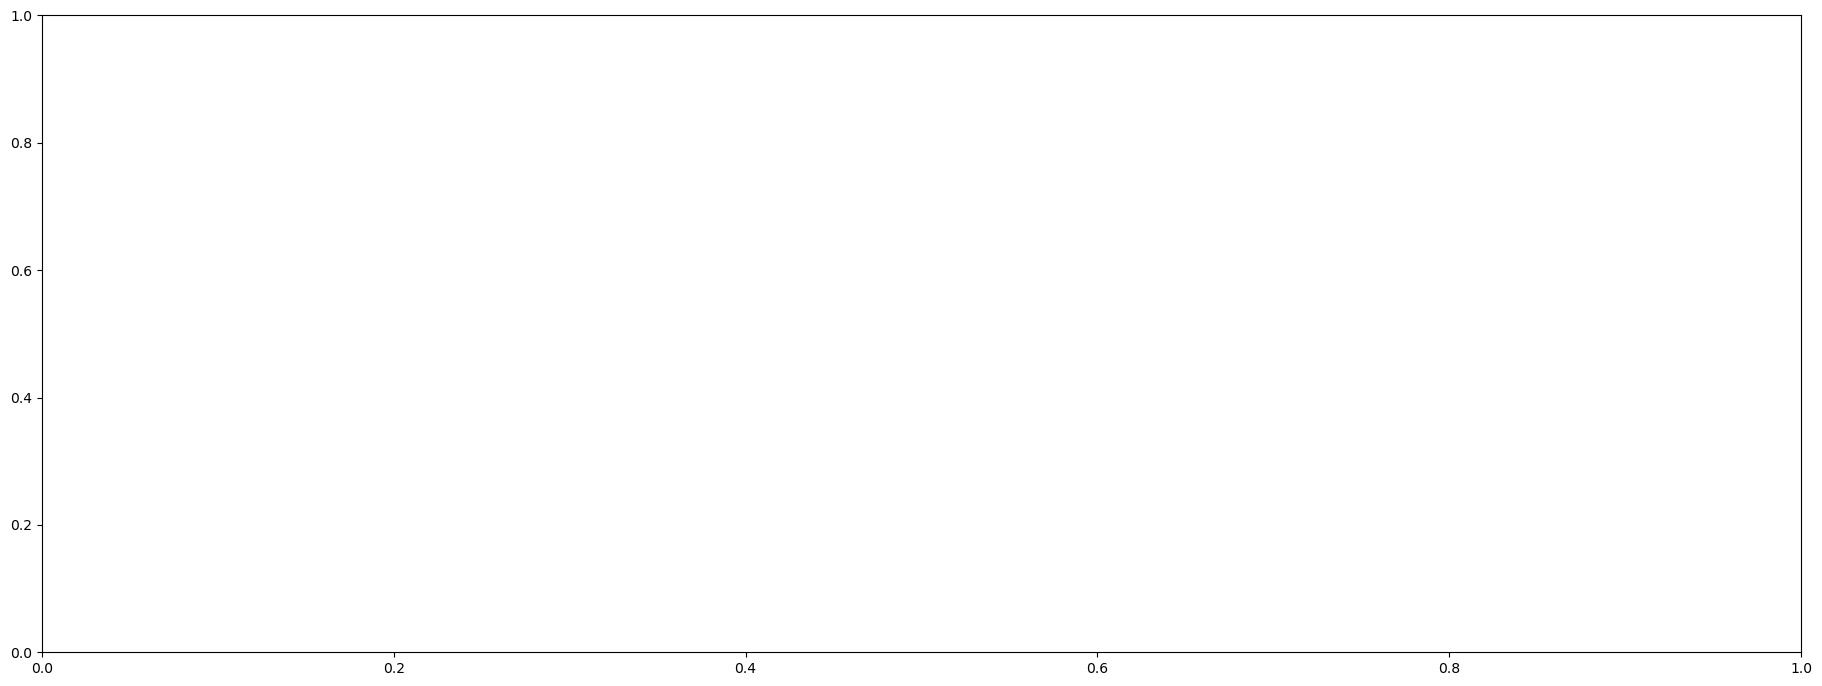

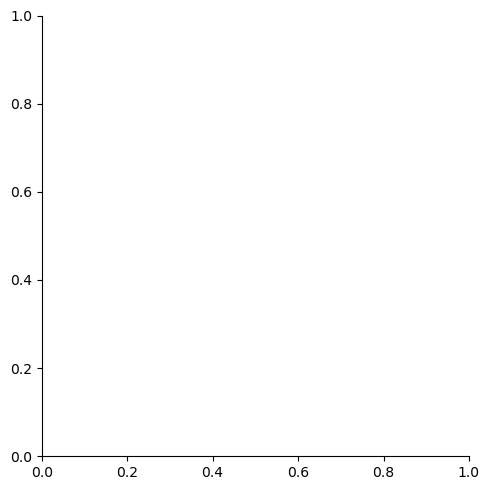

In [66]:
a4_dims = (22.7, 8.27)

fig, ax = plt.subplots(figsize=a4_dims)

sns.lmplot(data = edu_data, x = "name" , y = "count(retweet_count)")

plt.title('Relationship between Emergence of new issues in Education and the Location')
# Set x-axis label
plt.xlabel('Issues on education')
# Set y-axis label
plt.ylabel('Location of where the education issue occured')

In [76]:
tweet_df.groupby('text', 'reply_count').agg(count('retweet_count')).orderBy('count(retweet_count)', ascending=False).limit(5)


text,reply_count,count(retweet_count)
this is what sola...,5,188
I am thankful to ...,11,186
No Covid money is...,0,185
We’re counting do...,1,139
this is what sola...,4,132


### Part-1

In [98]:
drop_tweets = retweet_df.dropDuplicates(['text'])   #unique tweets and the average count of it and which text has the highest count
drop_tweets.groupby('text').agg(avg('retweeted_quote_count')).orderBy('avg(retweeted_quote_count)', ascending=False).limit(5).toPandas()

,text,avg(retweeted_quote_count)
0,"LeBron is paying $41 million to send 1,100 underprivileged kids to college. His foundation recently broke ground on… https://t.co/vOszM7aTyW",2493.0
1,Community college is still college and you’re still getting an education. You’ll save money and decrease student lo… https://t.co/CSnXEEu86X,1230.0
2,"In college I fell out of my bunk bed and broke both of my legs and one arm. Years later on a date, I made a joke ab… https://t.co/sEI4qsyvUU",1122.0
3,"2011 W university Dr McKinney, TX 75071\n\nYall know what to do.",964.0
4,This would be the biggest electoral college defeat of a sitting president since 1980.,845.0


### Part-2

In [99]:
extract_create_data = tweet_df.\
withColumn("day", tweet_df.retweeted_created_at.substr(0,2)).\
withColumn("year", tweet_df.retweeted_created_at.substr(26,29)).\
withColumn("month", tweet_df.retweeted_created_at.substr(4,8))

a = extract_create_data.toPandas()

In [100]:
a.head(3)

,quoted_status_id,country_code,city,retweeted_created_at,retweeted_quote_count,retweet_count,source,reply_count,retweeted,text,screen_name,id,description,statuses_count,day,year,month
0,1557626880,IE,Wicklow,Tue Jun 28 09:09:21 +0000 2022,0,1,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",0,False,@johnsweeneyroar Books. Mosul university. 2018.\n\nYou instantly reminded me of this. It's a terrible sight..\n\nhttps://t.co/l5juqDnHmX,irishelt,-1597844104,Irish Emergency Logistics Team: Professional Logisticians - Delivering Dignity Worldwide,87642,Tu,2022,Jun 28
1,1528238081,US,Knoxville,Sun Sep 11 20:50:08 +0000 2022,1,30,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",1,False,This is one of the many reasons using public tax dollars to fund schools with less or no transparency is a disaster… https://t.co/na1RnVzrE0,VoteGloriaJ,358432869,"State Rep. TN HD13 (HD90 in 2022). Retired special ed teacher, OFA Alum, healthcare advocate, public school supporter, she/her, #blm. Always standing TALL!",155293,Su,2022,Sep 11
2,1591033856,US,St Louis,Mon Jul 18 19:59:45 +0000 2022,0,1,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",0,False,"schools need to be early on my guy @evan_simon3 … lives in the gym, always studying film &amp; looking for ways to impr… https://t.co/Av6bFxlFBd",CoachJBAH,-1365819391,@ArsenalHoops @BHS_STL @BrandPatient,571,Mo,2022,Jul 18


<AxesSubplot:xlabel='day', ylabel='retweeted_quote_count'>

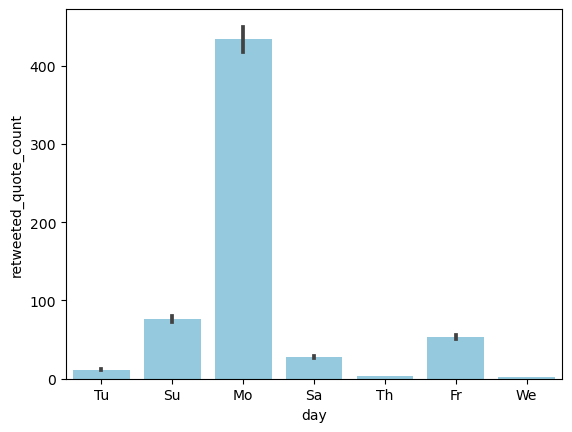

In [101]:
sns.barplot(data = a, x = "day" , y = "retweeted_quote_count" , color="skyblue")

In [102]:
# extract_create_data.groupby('day').agg(count('text')).limit(5).toPandas()

tweets_activity = extract_create_data.groupby('day').agg(count('text')).orderBy('count(text)', ascending=False).toPandas()



<AxesSubplot:xlabel='day', ylabel='count(text)'>

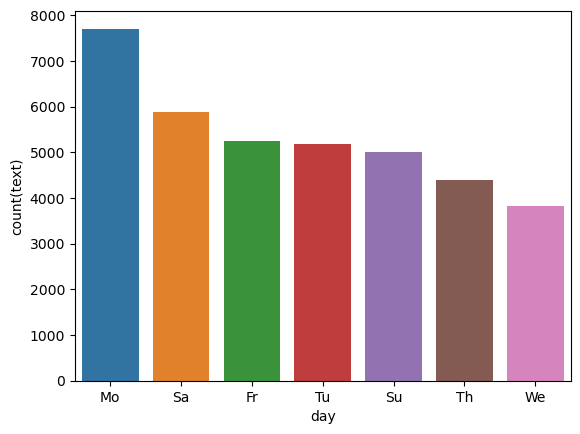

In [103]:
sns.barplot(data = tweets_activity, x = "day" , y = "count(text)")


### Part-3

Based on your analysis, are higher Tweet volumes reflective of the emergence of new hot topics in education? 

In [104]:

tweets_volumes = drop_tweets.groupby('city', 'text').agg(avg('retweeted_quote_count')).orderBy('avg(retweeted_quote_count)', ascending=False).limit(5).toPandas()



In [105]:
tweets_volumes.count()

city                          5
text                          5
avg(retweeted_quote_count)    5
dtype: int64

In [106]:
tweets_volumes.head(5)

,city,text,avg(retweeted_quote_count)
0,Ohio,"LeBron is paying $41 million to send 1,100 underprivileged kids to college. His foundation recently broke ground on… https://t.co/vOszM7aTyW",2493.0
1,Atlanta,I’m perfectly fine standing on this hill by myself. But wanting HBCU culture at white schools… instead of going to… https://t.co/HNGxWgV8Wq,1952.0
2,Desoto,Community college is still college and you’re still getting an education. You’ll save money and decrease student lo… https://t.co/CSnXEEu86X,1230.0
3,Memphis,"In college I fell out of my bunk bed and broke both of my legs and one arm. Years later on a date, I made a joke ab… https://t.co/sEI4qsyvUU",1122.0
4,Prairie View,"2011 W university Dr McKinney, TX 75071\n\nYall know what to do.",964.0


<AxesSubplot:xlabel='city', ylabel='avg(retweeted_quote_count)'>

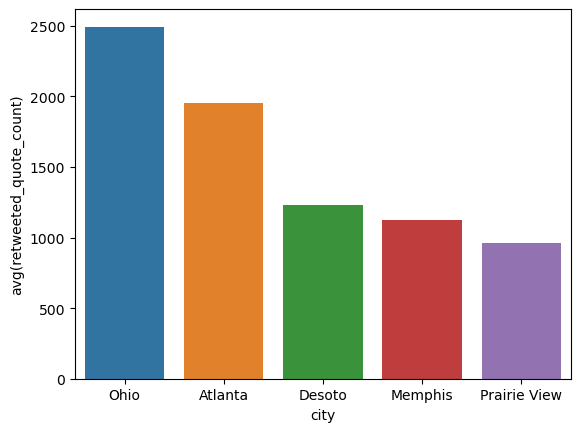

In [107]:
sns.barplot(data = tweets_volumes, x = "city" , y = "avg(retweeted_quote_count)")


### Part-4

#### Twitterers

In [108]:
extract_create_data.limit(5)

quoted_status_id,country_code,city,retweeted_created_at,retweeted_quote_count,retweet_count,source,reply_count,retweeted,text,screen_name,id,description,statuses_count,day,year,month
-99119102,US,Midland,Wed Aug 31 01:30:...,0,18,"<a href=""http://t...",2,false,Dear Greg Abbott:...,Miriam2626,96648433,Political and Leg...,159956,We,2022,Aug 31
-908722175,US,Marshall,Tue Aug 16 18:53:...,0,2,"<a href=""http://t...",0,false,What @paulgazelka...,k8bisch,-2089652524,"#Emplaw attorney,...",61357,Tu,2022,Aug 16
1226158080,SG,North-East Region,Tue Aug 30 13:02:...,0,3,"<a href=""http://t...",0,false,For all of those ...,aishakrist,1519669249,Passionate about ...,3756,Tu,2022,Aug 30
-2129158143,US,Jefferson City,Thu Apr 07 16:01:...,1,8,"<a href=""http://t...",3,false,Every time we tur...,AP4Liberty,391203010,Make America Free...,84934,Th,2022,Apr 07
-2129158143,US,Jefferson City,Thu Apr 07 16:01:...,1,9,"<a href=""http://t...",4,false,Every time we tur...,AP4Liberty,391203010,Make America Free...,84934,Th,2022,Apr 07


In [109]:
user_retweet_data = extract_create_data.select('screen_name', 'description', 'month', 'year', 'text', 'retweet_count', 'statuses_count', 'retweeted_quote_count')

user_retweet_data.limit(5).toPandas()


,screen_name,description,month,year,text,retweet_count,statuses_count,retweeted_quote_count
0,irishelt,Irish Emergency Logistics Team: Professional Logisticians - Delivering Dignity Worldwide,Jun 28,2022,@johnsweeneyroar Books. Mosul university. 2018.\n\nYou instantly reminded me of this. It's a terrible sight..\n\nhttps://t.co/l5juqDnHmX,1,87642,0
1,VoteGloriaJ,"State Rep. TN HD13 (HD90 in 2022). Retired special ed teacher, OFA Alum, healthcare advocate, public school supporter, she/her, #blm. Always standing TALL!",Sep 11,2022,This is one of the many reasons using public tax dollars to fund schools with less or no transparency is a disaster… https://t.co/na1RnVzrE0,30,155293,1
2,CoachJBAH,@ArsenalHoops @BHS_STL @BrandPatient,Jul 18,2022,"schools need to be early on my guy @evan_simon3 … lives in the gym, always studying film &amp; looking for ways to impr… https://t.co/Av6bFxlFBd",1,571,0
3,VickyStead,"Full time wife & mum to my 3 beautiful boys, part time Fundraiser & Health Care Assistant at Barnsley Hospice. Always burning the candle at both ends YOLO!",Jul 18,2022,I love my job in fundraising but visiting schools is the best part ⭐️ 👏🏻 #youngfundraisers #communitysupport,1,1086,0
4,BigHomieKODAQ,"Exec Prod: @bigfactspod • @thebeatatl 7pm-12am M- Thu • Hoodrich-@bighomieshouse• #CAU grad 📧:Kodaq@BigFactsPod.com Ft in: Shaderoom, Essence, ESPN ,RevoltTV",Sep 19,2022,I’m perfectly fine standing on this hill by myself. But wanting HBCU culture at white schools… instead of going to… https://t.co/HNGxWgV8Wq,4823,596482,2002


In [17]:
extract_description = tweet_df.\
withColumn("title", tweet_df.description.substr(0,15))

extract_description_df = extract_description
extract_description_df.limit(5)

quoted_status_id,country_code,name,retweeted_created_at,retweeted_quote_count,retweet_count,source,reply_count,retweeted,text,screen_name,id,description,statuses_count,title
580210690,US,Norman,Sun Apr 24 00:21:...,0,36,"<a href=""http://t...",6,false,The best fan base...,maureesee,-1497754425,OLB at The Univer...,2084,OLB at The Univ
-1210695678,US,Houston,Sun Apr 24 21:09:...,0,2,"<a href=""http://t...",0,false,Why is it that th...,KIR_bigg50,67494190,I am not a victim...,184858,I am not a vict
647331841,US,Monterey,Sun Apr 24 16:19:...,1,33,"<a href=""http://t...",8,false,He also opposed s...,Neoavatara,20729667,Radiologist and P...,370902,Radiologist and
-896069632,ZA,Johannesburg,Mon Apr 11 15:15:...,0,7,"<a href=""http://t...",0,false,"""If they give you...",Platinum_iced,190412579,SOCKSGANG_ENT. Co...,36948,SOCKSGANG_ENT.
374751241,US,Prospect,Mon Apr 11 18:03:...,1,2,"<a href=""http://t...",0,false,“I felt fear from...,StevenRummage,43577353,Mid-Day w/ @Maybi...,54972,Mid-Day w/ @May


### Who are these Twitterers (government entities / universities / schools / nonprofit organizations / news outlets / social media influencers / someone else)?

In [60]:
df = extract_description_df.filter((col("description").contains("education")) |
                                   (col("description").contains("school")) |
                                   (col("description").contains("university"))
                                  )


In [61]:
b = df.groupby('title').agg(count('retweeted_text')).orderBy('count(retweeted_text)', ascending=False).limit(12).toPandas()


In [62]:
b.head(5)

,title,count(retweeted_text)
0,State Represent,280
1,State Rep. TN H,135
2,Educator & Host,98
3,Committed to st,46
4,covering educat,41


Text(0, 0.5, 'Number of texts tweeted')

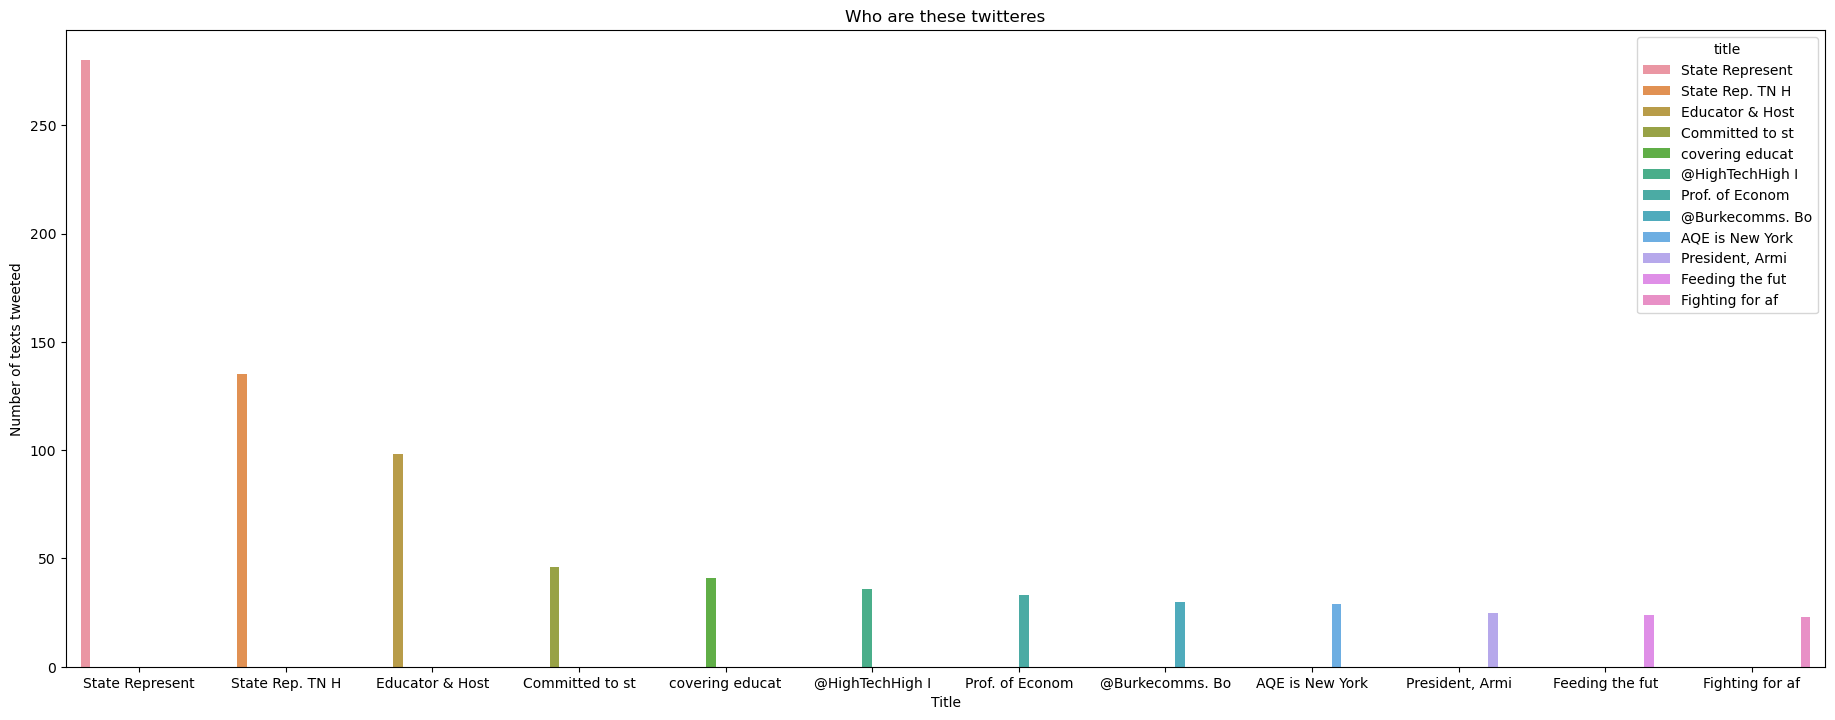

In [64]:
a4_dims = (22.7, 8.27)

fig, ax = plt.subplots(figsize=a4_dims)

# sns.scatterplot(data = b, x = "title" , y = "count(retweeted_text)", hue="title", ax=ax)
sns.barplot(data = b, x = "title" , y = "count(retweeted_text)", hue="title", ax=ax)

plt.title('Who are these twitteres')
# Set x-axis label
plt.xlabel('Title')
# Set y-axis label
plt.ylabel('Number of texts tweeted')

In [21]:
government_df = extract_description_df.filter((col("description").contains("government")) |
                                   (col("description").contains("State Represent")) |
                                   (col("description").contains("State Rep")) |
                                    (col("description").contains("President")) |
                                    (col("description").contains("Democratic")) |
                                    (col("description").contains("Political science")) 
                                             )
government_df.limit(5)

quoted_status_id,country_code,name,retweeted_created_at,retweeted_quote_count,retweet_count,source,reply_count,retweeted,text,screen_name,id,description,statuses_count,title
463110144,US,Nashville,Thu Sep 29 20:31:...,11,246,"<a href=""http://t...",19,false,.@GovBillLee’s fr...,jasonbmartin,17622662,Democratic nomine...,2310,Democratic nomi
-1147719680,US,Georgia,Sat Apr 30 14:03:...,0,2,"<a href=""http://t...",0,false,@eric_wearne is d...,GrantHewitt,21920151,Vice President of...,12240,Vice President
81084416,US,Porterville,Tue Aug 16 02:04:...,0,1,"<a href=""http://t...",0,false,It was great to m...,PortervillePrez,1515585536,President of Port...,1449,President of Po
2014969856,US,Missouri,Wed Oct 19 14:48:...,5,194,"<a href=""http://t...",15,false,Meet Jean Evans. ...,piper4missouri,1335234566,Teacher and Democ...,6015,Teacher and Dem
-2020110331,US,Nashville,Tue Jul 12 20:18:...,0,12,"<a href=""http://t...",1,false,I love how he adm...,VoteGloriaJ,358432869,State Representat...,152491,State Represent


In [22]:
health_df = extract_description_df.filter((col("description").contains("health")) |
                                   (col("description").contains("doctor")) |
                                   (col("description").contains("nurse")))
health_df.limit(2).toPandas()

,quoted_status_id,country_code,name,retweeted_created_at,retweeted_quote_count,retweet_count,source,reply_count,retweeted,text,screen_name,id,description,statuses_count,title
0,1528238081,US,Knoxville,Sun Sep 11 20:50:08 +0000 2022,1,30,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",1,False,This is one of the many reasons using public tax dollars to fund schools with less or no transparency is a disaster… https://t.co/na1RnVzrE0,VoteGloriaJ,358432869,"State Rep. TN HD13 (HD90 in 2022). Retired special ed teacher, OFA Alum, healthcare advocate, public school supporter, she/her, #blm. Always standing TALL!",155293,State Rep. TN H
1,-426094587,US,St Paul,Fri Oct 07 18:47:09 +0000 2022,1,5,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",0,False,This graph right here! 👇\nDeclining state investment in our public schools has led to huge revenue gaps. An over-rel… https://t.co/YdHYWjct4P,DeniseSpecht,27655477,Licensed MN elementary teacher. #Union. @EducationMN president. @AFTunion VP. Blocking the bullies and trolls for the health of it.,19818,Licensed MN ele


### Assessing the similarity on TEXT variables

In [24]:
government_df.limit(5)

quoted_status_id,country_code,name,retweeted_created_at,retweeted_quote_count,retweet_count,source,reply_count,retweeted,text,screen_name,id,description,statuses_count,title
-963178496,US,Knoxville,Fri Jul 29 18:11:...,5,88,"<a href=""http://t...",8,false,This is an import...,VoteGloriaJ,358432869,State Representat...,153586,State Represent
-1260744703,US,Mississippi,Thu Sep 22 16:39:...,1,29,"<a href=""http://t...",4,false,I'm so excited fo...,shuwaskiyoung,848695302,Girldad. Veteran....,976,Girldad. Vetera
-1621676023,US,Parma Heights,Sun Apr 10 21:40:...,49,521,"<a href=""http://t...",256,false,If you’re going t...,mirandayaver,1704646470,Political science...,100641,Political scien
-1621676023,US,Parma Heights,Sun Apr 10 21:40:...,49,522,"<a href=""http://t...",256,false,If you’re going t...,mirandayaver,1704646470,Political science...,100641,Political scien
-1621676023,US,Parma Heights,Sun Apr 10 21:40:...,32,329,"<a href=""http://t...",159,false,If you’re going t...,mirandayaver,1704646470,Political science...,100637,Political scien


In [25]:
df_text_raw = government_df.select(["text"])
df_text_raw.limit(5)

text
This is one of th...
All power to the ...
Look at the free ...
Punjab education ...
The best entrance...


In [26]:
text = df_text_raw.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")


tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

In [27]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])
df_text.limit(5)

text,id
{This is an impor...,316
{I'm so excited f...,317
{If you’re going ...,318
{If you’re going ...,319
{If you’re going ...,320


In [28]:
df_text.count()

2505

In [29]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[many, reasons, using, public, dollars, fund, schools, less, transparency, disaster…, https://t.co/na1rnvzre0]",0
1,"[power, @nw_ucu, @ucu, colleges, strike, today, support, amazing, across, union, https://t.co/l6qbtkns5s]",1
2,"[look, free, fall, young, people, signing, college, @govbilllee., disaster, education,, https://t.co/5oxvfkwszs]",2
3,"[punjab, education, model!, #1158assistantprofessorandlibrarians, \nthese, well, qualified, educated, youngs…, https://t.co/depyct3cmv]",3
4,"[best, entrance, college, football.]",4


In [30]:
df_tokens.printSchema()

root
 |-- list_of_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: long (nullable = true)



In [31]:
df_tokens.count()


2505

#### I used CountVectorizer function to create a Feature column to count the frequency of each word that occurs in the title. For instance, the first word in the second array - schools occured twice.

In [32]:
# Fit countvectorizer to create word features
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)


In [33]:
df_vectorize.limit(5).toPandas()


,list_of_words,id,features
0,"[many, reasons, using, public, dollars, fund, schools, less, transparency, disaster…, https://t.co/na1rnvzre0]",0,"(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[power, @nw_ucu, @ucu, colleges, strike, today, support, amazing, across, union, https://t.co/l6qbtkns5s]",1,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[look, free, fall, young, people, signing, college, @govbilllee., disaster, education,, https://t.co/5oxvfkwszs]",2,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[punjab, education, model!, #1158assistantprofessorandlibrarians, \nthese, well, qualified, educated, youngs…, https://t.co/depyct3cmv]",3,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[best, entrance, college, football.]",4,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


#### Used MinHashLSH from pyspark.ml.feature to create a hash table to estimate how similar each sets are to each other.

##### I chose 5 as the number of hash tables because it would provide a good balance of accuracy and speed.

In [34]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize)

##### Created a table of hash text that includes the 'ID', 'title', 'list of words', 'features' and the 5 permutations for each those features.

In [35]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left')
df_hashed_text.limit(5)

id,text,list_of_words,features,hashes
222,{.@GovBillLee’s f...,"[.@govbilllee’s, ...","(1866,[38,41,42,4...","[[1.8678956E7], [..."
270,{Because I stand ...,"[stand, funded, r...","(1866,[5,7,8,10,1...","[[1.19094037E8], ..."
293,{Because I stand ...,"[stand, funded, r...","(1866,[5,7,8,10,1...","[[1.19094037E8], ..."
243,{Look at the free...,"[look, free, fall...","(1866,[2,55,92,93...","[[1.31709234E8], ..."
278,{I couldn’t go to...,"[couldn’t, univer...","(1866,[109,537,74...","[[1.88730868E8], ..."


### Identify the right Jaccard similarity

##### First I used the jaccard distance of 30% to establish similarity threshold and return near-duplicate records.Used approxSimilarityJoin() to join the table 'df_hashed_text' to itself on a hash text value with those 5 permutations and taking 30% of the jaccard distance

#### Low Jaccard similarity

In [36]:
jaccard_distance = 0.3

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            ) 

In [37]:
df_dups_30 = df_dups_text
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.0,3,450,"(Punjab education model! #1158AssistantProfessorAndLibrarians \nThese are the most well qualified and educated youngs… https://t.co/dEPyCt3cmv,)","(Punjab education model! #1158AssistantProfessorAndLibrarians \nThese are the most well qualified and educated youngs… https://t.co/dEPyCt3cmv,)"
1,0.0,138,469,"(Because I stand for funded roads and schools, I should…move to California? Rural Missourians deserve more. We deser… https://t.co/X6YLdrEBYE,)","(Because I stand for funded roads and schools, I should…move to California? Rural Missourians deserve more. We deser… https://t.co/X6YLdrEBYE,)"
2,0.0,44,506,"(🧵The sooner everyone acknowledges that teacher shortages are the result of intentional, strategic policies enacted… https://t.co/mjDUq0uBYF,)","(🧵The sooner everyone acknowledges that teacher shortages are the result of intentional, strategic policies enacted… https://t.co/mjDUq0uBYF,)"
3,0.0,357,487,"(If you’re going to lie about graduating in the top 1% of one’s class, or graduating from college at all, maybe act… https://t.co/2ORqB426p0,)","(If you’re going to lie about graduating in the top 1% of one’s class, or graduating from college at all, maybe act… https://t.co/2ORqB426p0,)"
4,0.0,92,487,"(If you’re going to lie about graduating in the top 1% of one’s class, or graduating from college at all, maybe act… https://t.co/2ORqB426p0,)","(If you’re going to lie about graduating in the top 1% of one’s class, or graduating from college at all, maybe act… https://t.co/2ORqB426p0,)"


In [38]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate texts based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique texts based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  2505
Duplicate texts based on { 0.3 } jaccard distance:  2228
Unique texts based on { 0.3 } jaccard distance:  0.3 :  277


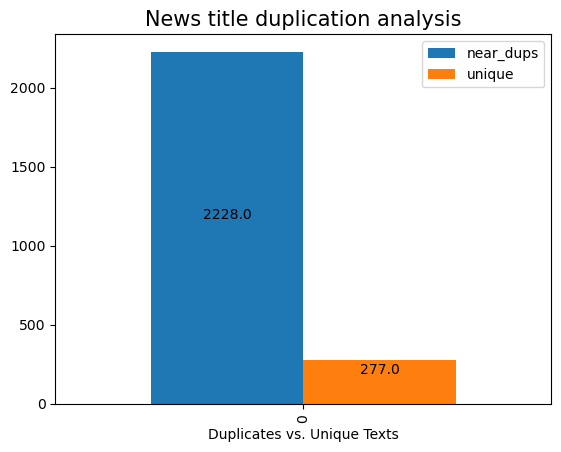

In [39]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique Texts")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

<AxesSubplot:ylabel='Frequency'>

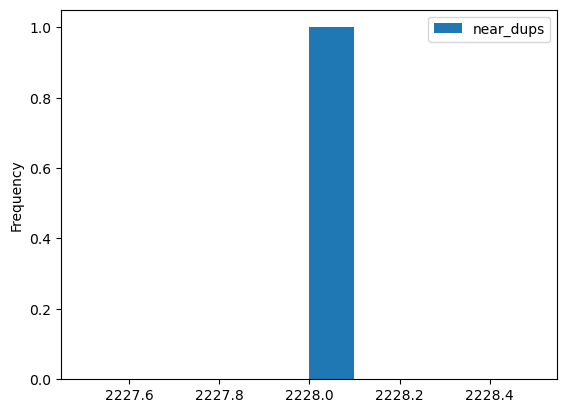

In [40]:
dups_df.plot(kind = 'hist',y='near_dups', fontsize=10, xlabel="Overall distribution of “near-duplication of 30%")


#### When performing the jaccard distance of 30%, there are 29380 duplicate texts and 7875 unique texts.

### Medium Jaccard similarity

##### Then I used the jaccard distance of 50% to establish similarity threshold and return near-duplicate records.Used approxSimilarityJoin() to join the table 'df_hashed_text' to itself on a hash text value with those 5 permutations and taking 50% of the jaccard distance

In [41]:
jaccard_distance = 0.5

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            ) 

In [42]:
df_dups_50 = df_dups_text
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.0,168,392,"(Because I stand for funded roads and schools, I should…move to California? Rural Missourians deserve more. We deser… https://t.co/X6YLdrEBYE,)","(Because I stand for funded roads and schools, I should…move to California? Rural Missourians deserve more. We deser… https://t.co/X6YLdrEBYE,)"
1,0.0,171,327,"(Because I stand for funded roads and schools, I should…move to California? Rural Missourians deserve more. We deser… https://t.co/X6YLdrEBYE,)","(Because I stand for funded roads and schools, I should…move to California? Rural Missourians deserve more. We deser… https://t.co/X6YLdrEBYE,)"
2,0.0,67,347,"(If you’re going to lie about graduating in the top 1% of one’s class, or graduating from college at all, maybe act… https://t.co/2ORqB426p0,)","(If you’re going to lie about graduating in the top 1% of one’s class, or graduating from college at all, maybe act… https://t.co/2ORqB426p0,)"
3,0.0,322,427,"(If you’re going to lie about graduating in the top 1% of one’s class, or graduating from college at all, maybe act… https://t.co/2ORqB426p0,)","(If you’re going to lie about graduating in the top 1% of one’s class, or graduating from college at all, maybe act… https://t.co/2ORqB426p0,)"
4,0.0,68,321,"(If you’re going to lie about graduating in the top 1% of one’s class, or graduating from college at all, maybe act… https://t.co/2ORqB426p0,)","(If you’re going to lie about graduating in the top 1% of one’s class, or graduating from college at all, maybe act… https://t.co/2ORqB426p0,)"


In [43]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate texts based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique texts based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  2505
Duplicate texts based on { 0.5 } jaccard distance:  2228
Unique texts based on { 0.5 } jaccard distance:  0.5 :  277


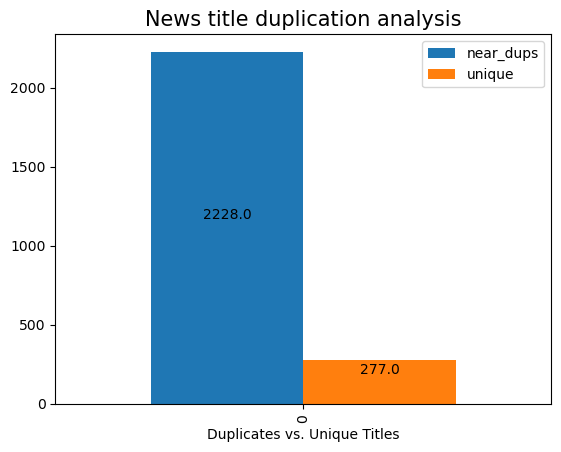

In [44]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique Titles")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

<AxesSubplot:ylabel='Frequency'>

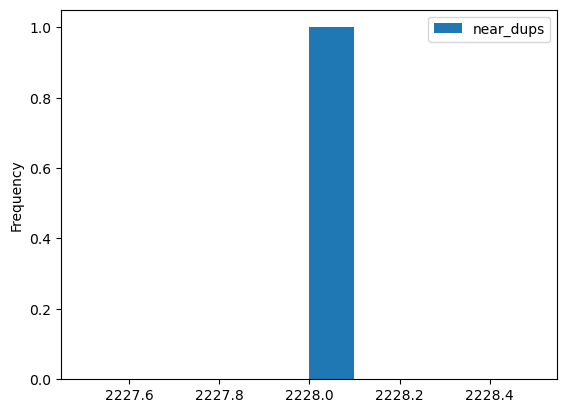

In [45]:
dups_df.plot(kind = 'hist',y='near_dups', fontsize=10, xlabel="Overall distribution of “near-duplication of 50%")

#### When performing the jaccard distance of 50%, there are 29431 duplicate texts and 7824 unique texts.

#### High Jaccard Similarity 

In [46]:
jaccard_distance = 0.7

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            ) 

In [47]:
df_dups_70 = df_dups_text
df_dups_70.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.0,10,216,"(Because I stand for funded roads and schools, I should…move to California? Rural Missourians deserve more. We deser… https://t.co/X6YLdrEBYE,)","(Because I stand for funded roads and schools, I should…move to California? Rural Missourians deserve more. We deser… https://t.co/X6YLdrEBYE,)"
1,0.0,167,222,"(.@GovBillLee’s friends at Hillsdale finally saw the light: Tennessee doesn’t want “schools” that are just profit ce… https://t.co/ka9KofD8t8,)","(.@GovBillLee’s friends at Hillsdale finally saw the light: Tennessee doesn’t want “schools” that are just profit ce… https://t.co/ka9KofD8t8,)"
2,0.0,236,314,"(Meet Jean Evans. She is the Director of an organization that wants to privatize Missouri’s public schools. All resi… https://t.co/B9wgXo7lGQ,)","(Meet Jean Evans. She is the Director of an organization that wants to privatize Missouri’s public schools. All resi… https://t.co/B9wgXo7lGQ,)"
3,0.0,89,209,"(These are the views @GovBillLee wants in our schools.,)","(These are the views @GovBillLee wants in our schools.,)"
4,0.0,24,270,"(Because I stand for funded roads and schools, I should…move to California? Rural Missourians deserve more. We deser… https://t.co/X6YLdrEBYE,)","(Because I stand for funded roads and schools, I should…move to California? Rural Missourians deserve more. We deser… https://t.co/X6YLdrEBYE,)"


In [48]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate texts based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique texts based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  2505
Duplicate texts based on { 0.7 } jaccard distance:  2229
Unique texts based on { 0.7 } jaccard distance:  0.7 :  276


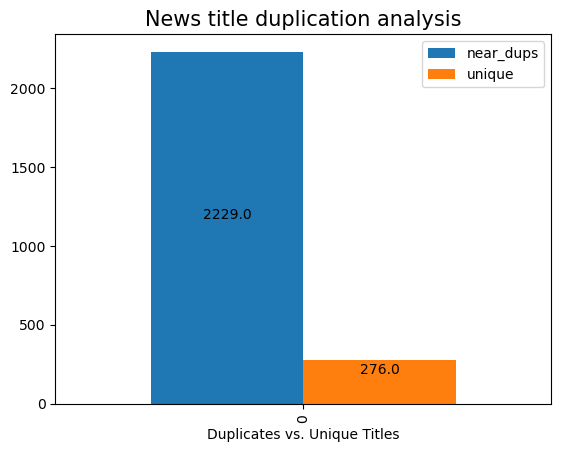

In [49]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique Titles")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

<AxesSubplot:ylabel='Frequency'>

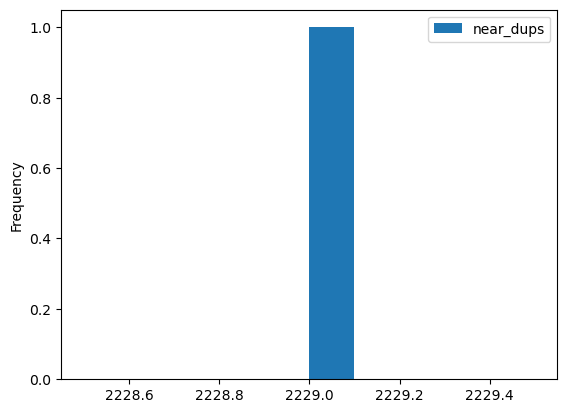

In [50]:
dups_df.plot(kind = 'hist',y='near_dups', fontsize=10, xlabel="Overall distribution of “near-duplication of 50%")

### Compare jaccard distance

In [1]:
df_dups_30_id = df_dups_30.select(col('id_A').alias('id_30_A'), col('id_B').alias('id_30_B'))
df_dups_50_id = df_dups_50.select(col('id_A').alias('id_50_A'), col('id_B').alias('id_50_B'))
df_dups_70_id = df_dups_70.select(col('text_A'), col('text_B'),\
                                  col('id_A').alias('id_70_A'), col('id_B').alias('id_70_B'))

print(df_dups_30_id.count())
print(df_dups_50_id.count())
print(df_dups_70_id.count())

NameError: name 'df_dups_30' is not defined

In [ ]:
dups_combined = df_dups_70_id.join(df_dups_50_id, on=((df_dups_70_id.id_70_A == df_dups_50_id.id_50_A) & (df_dups_70_id.id_70_B == df_dups_50_id.id_50_B)), how="left_outer")\
.join(df_dups_30_id, on=((df_dups_70_id.id_70_A == df_dups_30_id.id_30_A) & (df_dups_70_id.id_70_B == df_dups_30_id.id_30_B)), how="left_outer")

dups_combined.limit(5)

22/12/08 07:28:56 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 4.0 in stage 402.0 (TID 9839) (hub-msca-bdp-dphub-students-backup-shuklakm-w-1.c.msca-bdp-students.internal executor 106): TaskKilled (Stage cancelled)


In [ ]:
dups_combined = dups_combined.\
withColumn("threshold_30",\
           when(col("id_30_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
withColumn("threshold_50",\
           when(col("id_50_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
withColumn("threshold_70",\
           when(col("id_70_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
drop('id_30_A', 'id_30_B', 'id_50_A', 'id_50_B', 'id_70_A', 'id_70_B')

# Retweet

In [15]:
retweeted_data = spark.read.parquet(gs_read_retweeted_status_text_filt_path, header='true', inferSchema='true')

In [16]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [17]:
retweeted_data.count()

37713

In [25]:
retweet_df = retweeted_data.withColumn("retweeted_quote_count", retweeted_data["retweeted_quote_count"].cast(IntegerType())).\
                            withColumn("retweet_count", retweeted_data["retweet_count"].cast(IntegerType())).\
                            withColumn("reply_count", retweeted_data["reply_count"].cast(IntegerType()))           
                                       

retweet_df.printSchema()

root
 |-- quoted_status_id: long (nullable = true)
 |-- country_code: string (nullable = true)
 |-- name: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- retweeted_quote_count: integer (nullable = true)
 |-- retweet_count: integer (nullable = true)
 |-- source: string (nullable = true)
 |-- reply_count: integer (nullable = true)
 |-- retweeted: boolean (nullable = true)
 |-- retweeted_text: string (nullable = true)



In [26]:
retweet_df.describe()

summary,quoted_status_id,country_code,name,created_at,retweeted_quote_count,retweet_count,source,reply_count,retweeted_text
count,37713,37713,37713,37713,37713,37713,37713,37713,37713
mean,1.548209146473786...,null,null,null,112.65855275369236,611.9817304377801,null,62.39180123564819,null
stddev,4.334116398710070...,null,null,null,362.3343289653208,1716.0483820677293,null,151.31343912910432,null
min,127774804269998081,AE,A Coruña,Fri Apr 01 13:22:...,0,1,"<a href=""http://i...",0,""" logon ka khoon ..."
max,1589367684562444288,ZW,西東京市,Wed Sep 28 23:41:...,2505,118674,"<a href=""https://...",2539,🫶🏻🫶🏻🫶🏻 I lo...


In [27]:
retweet_df.limit(5).toPandas()

,quoted_status_id,country_code,name,created_at,retweeted_quote_count,retweet_count,source,reply_count,retweeted,retweeted_text
0,1555867415891742722,PA,Panama,Sat Aug 06 13:28:05 +0000 2022,1,9,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",1,False,"Right, Gustavo! Far too often, the essence of education is absent from educational curricula, and there is a signif… https://t.co/BD3jZ8gFBW"
1,1554851031670001667,US,Bloomfield Township,Sat Aug 06 20:32:25 +0000 2022,0,5,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",8,False,Back in college a physics major in my dorm once got drunk and shoved a green bean up his nose on a bet. We had to t… https://t.co/QlMBtVmFjs
2,1555955158156136448,CA,Saskatoon,Sat Aug 06 16:50:17 +0000 2022,0,28,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",8,False,Sask apparently has a hillbilly loophole where anyone with Grade 12 can teach at taxpayer-funded Christian schools… https://t.co/RO3OMeCmJ3
3,1581855426131685376,GB,Horspath,Mon Oct 17 07:32:32 +0000 2022,0,5,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",0,False,Well done to all involved in co-producing this Eating Disorder Tool Kit for schools ⭐️ I work in an inpatient CAMHS… https://t.co/NdvV9lost4
4,1519325715233230848,US,Cranford,Wed Apr 27 15:15:47 +0000 2022,0,1,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",0,False,Top 25 in the country. Let that sink in!!! #owlpride #unioncountycollege #owlnation


# USER

In [10]:
user_data = spark.read.parquet(gs_read_user_selected_data_filt_path, header='true', inferSchema='true')
# retweeted_data = spark.read.parquet(gs_read_retweeted_status_text_filt_path, header='true', inferSchema='true')
# quotes_data = spark.read.parquet(gs_read_quoted_status_text_path, header='true', inferSchema='true')


In [11]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [12]:
user_data.count()

61718214

In [13]:
user_data.printSchema()

root
 |-- id: long (nullable = true)
 |-- location: string (nullable = true)
 |-- name: string (nullable = true)
 |-- statuses_count: long (nullable = true)
 |-- description: string (nullable = true)
 |-- verified: boolean (nullable = true)



In [14]:
user_data.limit(5).toPandas()

,id,location,name,statuses_count,description,verified
0,861502782,"Kampala, Uganda",D I A N A🔴,233479,TECH👩🏽‍💻. Entrepreneur. Always Be humble! DM for Business Advert & Promotion. Business ideas. Follow & Support @TukoOutfits,False
1,1406129682647425033,KWANGYA,Jae 🍂,5045,"aespink, Minjeong ☆ - WinNing OST OUT NOW",False
2,603126135,"Durham, UK",Durham Law School,4878,DLS is one of the best in the UK and ranked in the top 50 of both the QS and THE World Rankings. Follow us for updates on our world class research & education.,False
3,905711496,Twitter,ֆʏɛɖ ֆɦǟɦɛɖ,6974,I Always Stand With Truth Whether It's My Friends Or My Enemies,False
4,1519218990081613824,Wherever my wings take me.,GFD,539,A Mandarin of mystery. Master of mnemonics. GoodFlyingDuck is a Phoenix. Risen from the ashes. Say it with Feathers! 😋,False
